**Name : Anoop John Alocious**

**ID : 31084354**

**Kaggle ID : AJohn**

**PART A - Recommender Systems**

In this notebook, we will be focusing on building recommendation systems for flickr dataset. The data provided to us consists of different users and different items, for which each user has interacted with. Our main is to build a recommendation system that can help recommend relevant items to the users.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# installing Implicit package 
!pip install implicit

     |████████████████████████████████| 1.1MB 5.4MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406428 sha256=6a3ccf580f419d5071869211204ef68ea52e6125e222d0d2cfa820f585a0f0df
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


**Importing Libraries**

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse
import implicit

**Reading All the files**


In [5]:
train = pd.read_csv('flickr_train_data.csv')
item_features = pd.read_csv('flickr_item_fea.csv')
links = pd.read_csv('flickr_links.csv')
usr_features = pd.read_csv('flickr_user_fea.csv')
test = pd.read_csv('flickr_test_data.csv')
validation_set = pd.read_csv('flickr_validation_data.csv')

**Inspecting the training data**

In [6]:
train.head(5)

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


**Checking for Duplicates & Item value counts**

We will be dropping the duplicates in the training set, if any found. And just for curiousity, we would like to check the item that was liked by most users.

In [7]:
train = train.drop_duplicates()
train['item_id'].value_counts()

49      110
2486    101
3990     91
774      85
1429     79
       ... 
2511      4
3716      4
829       4
2540      4
2922      4
Name: item_id, Length: 9004, dtype: int64

In [8]:
train.dtypes

user_id    int64
item_id    int64
rating     int64
dtype: object

**Creating Sparse Matrices**

In this step, we will creating user-item and item-user interaction matrix. We will use the user-item interaction matrix to build the model, whereas using the latter will be used for the recommending step.

In [9]:
# creating item-user interaction matrix
sparse_item_user = sparse.csr_matrix((train['rating'].astype(float), (train['item_id'], train['user_id'])))

# creating user-item interaction matrix
sparse_user_item = sparse.csr_matrix((train['rating'].astype(float), (train['user_id'], train['item_id'])))

In [10]:
sparse_item_user

<9004x3466 sparse matrix of type '<class 'numpy.float64'>'
	with 110129 stored elements in Compressed Sparse Row format>

In [11]:
sparse_user_item

<3466x9004 sparse matrix of type '<class 'numpy.float64'>'
	with 110129 stored elements in Compressed Sparse Row format>

**DCG AND NDCG Calculation**

The metric used to evaluate model performance is the Normalized Discounted Cumulative Gain. We will be mainly using this function for the hyper-parameter tuning step, where we will tune all the hyper parameters. 
NDCG is the ratio of a users DCG score over the ideal ranking of the DCG score.

In [12]:
import math

# computing ndcg score for the validation item 
def ndcg_score(rec_list, valid_item):
  try:
    i = rec_list.index(valid_item)
    ndcg = math.log(2)/ math.log(i+2)
  except ValueError:
    ndcg = 0.0
  return ndcg

**Creating the Recommend Function**

This function is used to create a recommended list of items for each user. It returns the item_id based on the sorted values of the dot product of the user and the item-user matrix. 

In [13]:
def recommend(person_id, sparse_matrix, person_vecs, content_vecs):
    # Get the interactions scores from the sparse person content matrix
    person_interactions = sparse_matrix[person_id,:].toarray()
    #print(person_interactions)
    person_interactions = person_interactions.reshape(-1) + 1
    person_interactions[person_interactions > 1] = 0
    rec_vector = person_vecs[person_id,:].dot(content_vecs.T).toarray()
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    # Content already interacted have their recommendation multiplied by zero
    recommend_vector = person_interactions * rec_vector_scaled
    # Sort the indices of the content into order of best recommendations
    content_idx = np.argsort(recommend_vector)[::-1]
    # returning the sorted list of recommendations
    return content_idx

**Alternating Least Squares**

Matrix Factorization is a method to generate latent variables when multiplying 2 different sparse matrices. In Collaborative Filtering, this is exactly what we do, as in, we take the users and items matrices, and we tend to identify the relationship between the users and items. For our task, using the inputs of the users rating for each item, we would like to recommend new items to the user from a candidate list of items.

The dot product of user and item matrix can generate the rating matrix, while the user matrix is the shape of k (users) * f (features) and the item matrix is the shape of j(items) * f (features). From user’s and item’s matrices, we can identify the relationship where in our case, it is whether the user has liked the photo or not.

The alternating least squares (ALS) algorithm factorizes a given matrix S into two factor matrices U and V such that S ≈ U(Transpose) * V.

**Hyper Parameter Tuning**

In this step, we will tune the hyper parameters for different models using the function below.
We have used different values for alpha, number of factors, and regularization values & iterations.
We will be tuning the hyper parameters based on the validation set, and we will compute the NDCG score for each result. Based on the top NDCG score, we will finalize the best parameters for our model.

In [69]:
# parameter tuning
from collections import defaultdict

def hyper_parameter_tuning(model_type):
  """model_type: ALS, LMF, BPS"""
  best_params = defaultdict(list)
  users = set(train.user_id.tolist())
  #column_names = ["user_id", "item_id"]
  alpha_val = [25,50]
  factors = [7,8,10]
  reg_val = [0.1]
  iterations = [100,105]
  for alpha in alpha_val:
    #df = pd.DataFrame(columns = column_names)
    for fac in factors:
      for values in reg_val:
        for iter in iterations:
          data = (sparse_item_user * alpha).astype('double')
          data[1,:].todense()
          if (model_type == 'ALS'):
            model = implicit.als.AlternatingLeastSquares(factors=fac, regularization=values, iterations=iter, use_gpu = False)
          elif (model_type == 'LMF'):
            model = implicit.lmf.LogisticMatrixFactorization(factors=fac, regularization=values, iterations=iter, use_gpu = False)
          else:
            model = implicit.bpr.BayesianPersonalizedRanking(factors=fac, regularization=values, iterations=iter, use_gpu = False)
          model.fit(data)
          person_vecs = sparse.csr_matrix(model.user_factors)
          content_vecs = sparse.csr_matrix(model.item_factors)
          score_list = []
          for i in range(0, len(users)):
      #print(i)
            x = recommend(i, sparse_user_item, person_vecs, content_vecs)[:15]
            y = validation_set.loc[validation_set['user_id'] == i,'item_id'].tolist()[0]
            #c = [0] * 15
            
            score = ndcg_score(list(x), y)
            score_list.append(score)
          print(len(score_list))
          mean_dcg = sum(score_list)/len(score_list)
          best_params['alpha'].append(alpha)
          best_params['factors'].append(fac)
          best_params['reg'].append(values)
          best_params['iterations'].append(iter)
          best_params['avg_ndcg'].append(mean_dcg)
  return best_params

In [70]:
# Hyper parameter Tuning Results
results = hyper_parameter_tuning('ALS')
valid_results = pd.DataFrame(results)
valid_results = valid_results.sort_values('avg_ndcg', ascending=False)


3466



3466



3466



3466



3466



3466



3466



3466



3466



3466



3466



3466


**Building Model**

From the previous step, we have obtained the hyper parameters for the model. We will plug use those values to build a good ALS model in this step.

Alpha (α) = 50<br>
Factors of the latent variables = 8<br>
Regularization = 0.1 <br>
Iteration = 100

In [22]:
alpha = 50
data = (sparse_item_user * alpha).astype('double')
data[1,:].todense()
model = implicit.als.AlternatingLeastSquares(factors=8, regularization=0.1, iterations=100, use_gpu = False)
model.fit(data)

**Computing Results**

We will get the top 15 recommendations for each user from the 100 candidate items in the testing set. We will create a new dataframe to store these values, so that we can use it to calculate the NDCG for the entire testset on Kaggle. The new dataframe will be exported as a .csv file, which will be submitted on Kaggle.

In [20]:
# getting user and item model factors
person_vecs = sparse.csr_matrix(model.user_factors)
content_vecs = sparse.csr_matrix(model.item_factors)

# getting unique user ID's
users = set(train.user_id.tolist())
column_names = ["user_id", "item_id"]
# dataframe with the final recommendations for each user. To be uploaded in kaggle
df = pd.DataFrame(columns = column_names)
#df1 = pd.DataFrame(columns = column_names)
for i in range(0, len(users)):
    #print(i)
    x = recommend(i, sparse_user_item, person_vecs, content_vecs)
    y = set(test.loc[test['user_id'] == i,'item_id'].tolist())
    t = []
    u = []
    count = 0
    for j in x:
      if count < 15:
        if j in y:
          t.append(j)
          u.append(i)
          count = count + 1
      else:
        break
    recommendations = pd.DataFrame({'user_id': u, 'item_id': t})
    df = df.append(recommendations, ignore_index=True)

In [17]:
df.shape

(51990, 2)

Finally, we are converting the dataframe with all the user-item recommendations into a dataframe.

In [21]:
df.to_csv('31084354_output.csv', index=False)


**Logistic Matrix Factorization**

This is another collaborative filtering algorithm which uses the user-item interactions to build a probability distribution for checking whether the user likes an item or not.

We will be implementing this algorithm using the implicit package, the same package we used to build the ALS model. The input and the number of hyper parameters are the same for this model too.

In [71]:
# Hyper parameter Tuning Results
results = hyper_parameter_tuning('LMF')
valid_results = pd.DataFrame(results)
valid_results = valid_results.sort_values('avg_ndcg', ascending=False)


  5%|▍         | 5/105 [00:00<00:02, 49.03it/s]

3466


  4%|▍         | 4/100 [00:00<00:02, 37.18it/s]

3466


  4%|▍         | 4/105 [00:00<00:02, 37.99it/s]

3466


  4%|▍         | 4/100 [00:00<00:02, 37.68it/s]

3466


  4%|▍         | 4/105 [00:00<00:02, 39.13it/s]

3466


  6%|▌         | 6/100 [00:00<00:01, 52.93it/s]

3466


  5%|▍         | 5/105 [00:00<00:02, 49.47it/s]

3466


  5%|▌         | 5/100 [00:00<00:02, 37.79it/s]

3466


  5%|▍         | 5/105 [00:00<00:02, 48.34it/s]

3466


  4%|▍         | 4/100 [00:00<00:02, 36.71it/s]

3466


  4%|▍         | 4/105 [00:00<00:02, 37.83it/s]

3466


100%|██████████| 105/105 [00:02<00:00, 38.20it/s]


3466


**Building Model**

From the previous step, we have obtained the hyper parameters for the model. We will plug use those values to build a good LMF model in this step.

Alpha (α) = 25<br>
Factors of the latent variables = 8<br>
Regularization = 0.1 <br>
Iteration = 105

In [ ]:
alpha = 25
data = (sparse_item_user * alpha).astype('double')
data[1,:].todense()
model2 = implicit.lmf.LogisticMatrixFactorization(factors=8, regularization=0.1, iterations=105, use_gpu = False)
model2.fit(data)

100%|██████████| 105/105 [00:02<00:00, 51.30it/s]


In [ ]:
# getting user and item model factors
person_vecs = sparse.csr_matrix(model2.user_factors)
content_vecs = sparse.csr_matrix(model2.item_factors)

# getting unique user ID's
users = set(train.user_id.tolist())
column_names = ["user_id", "item_id"]
df = pd.DataFrame(columns = column_names)
#df1 = pd.DataFrame(columns = column_names)
for i in range(0, len(users)):
    #print(i)
    x = recommend(i, sparse_user_item, person_vecs, content_vecs)
    y = set(test.loc[test['user_id'] == i,'item_id'].tolist())
    t = []
    u = []
    count = 0
    for j in x:
      if count < 15:
        if j in y:
          t.append(j)
          u.append(i)
          count = count + 1
      else:
        break
    recommendations = pd.DataFrame({'user_id': u, 'item_id': t})
    df = df.append(recommendations, ignore_index=True)

**Computing Results**

Using the LMF model created using the best parameters, we were getting n NDCG score of 0.10 on the test data. This justifies the fact that the LMF is not an accurate model for our task.

**Bayesian Personalized Ranking**

This is another algorithm provided by the implicit package, which can be used for building recommendation system. The main feature of this algorithm is that it incorporates bayesian analysis by considering the likelihood function for each user-item interaction and also the prior probability of the model parameters.

In [72]:
# Hyper parameter Tuning Results
results = hyper_parameter_tuning('BPR')
valid_results = pd.DataFrame(results)
valid_results = valid_results.sort_values('avg_ndcg', ascending=False)


3466



3466



3466



3466



3466



3466



3466



3466



3466



3466



3466



3466


**Building Model**

From the previous step, we have obtained the hyper parameters for the model. We will plug use those values to build a good BPR model in this step.

Alpha (α) = 25<br>
Factors of the latent variables = 7<br>
Regularization = 0.1 <br>
Iteration = 100

In [73]:
alpha = 25
data = (sparse_item_user * alpha).astype('double')
data[1,:].todense()
model3 = implicit.bpr.BayesianPersonalizedRanking(factors=7, regularization=0.1, iterations=100, use_gpu = False)
model3.fit(data)

In [ ]:
# getting user and item model factors
person_vecs = sparse.csr_matrix(model3.user_factors)
content_vecs = sparse.csr_matrix(model3.item_factors)

# getting unique user ID's
users = set(train.user_id.tolist())
column_names = ["user_id", "item_id"]
df = pd.DataFrame(columns = column_names)
#df1 = pd.DataFrame(columns = column_names)
for i in range(0, len(users)):
    #print(i)
    x = recommend(i, sparse_user_item, person_vecs, content_vecs)
    y = set(test.loc[test['user_id'] == i,'item_id'].tolist())
    t = []
    u = []
    count = 0
    for j in x:
      if count < 15:
        if j in y:
          t.append(j)
          u.append(i)
          count = count + 1
      else:
        break
    recommendations = pd.DataFrame({'user_id': u, 'item_id': t})
    df = df.append(recommendations, ignore_index=True)

**Computing Results**

Using the BPR model created using the best parameters, we were getting n NDCG score of 0.06 on the test data, which is significantly lower than the ALS and LMF models.


**Neural Collaborative Filtering**

Neural Collaborative Filtering (NCF) replaces the user-item interaction as seen in the matrix factorization with a neural architecture. Due to this architecture, the NCF tries to achieve the following:
1. It tries to generalize Matrix Factorization 
2. It tries to learn user-item interactions using a multi-layer perceptron.

We will be building this model using Keras & Tensorflow.

TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications. 
One of the main use-case of this platform is to build and train ML models easily using intuitive high-level APIs like Keras with eager execution, which makes for immediate model iteration and easy debugging

In [ ]:
!pip install tensorflow lightfm pandas

**Importing Libraries**

In [80]:
import datetime
import os
import lightfm
import tensorflow as tf
from lightfm import LightFM
from scipy import sparse
from tensorboard import notebook
from typing import List
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


We will be building functions to convert the long arrays into table, so that it is easier to perform operations.

In [84]:
# Function to convert table from wide to long.
def convert_table(wide: np.array, ratings: List[int]) -> np.array:
    
    # getting the ratings
    def _get_ratings(arr: np.array, rating: int) -> np.array:
        idx = np.where(arr == rating)
        return np.vstack(
            (idx[0], idx[1], np.ones(idx[0].size, dtype="int64") * rating)
        ).T
    lg_array = []
    for r in ratings:
        lg_array.append(_get_ratings(wide, r))

    return np.vstack(lg_array)

**Creating the user-item interaction matrix**

We will be building the sparse user-item interaction matrix which displays the interaction of each user for each item. If the value is '1', it suggests that the user has liked the item, whereas if it is '0', either the user has not viewed the item or he/she did not like it.

In [85]:
# creating sparse matrix for user-item interaction
sparse_user_item = sparse.csr_matrix((train['rating'].astype(float), (train['user_id'], train['item_id'])))

In [86]:
# converting the matrix to array
x = sparse_user_item.toarray()

#getting the unique values
unique_ratings = np.unique(x)
print(unique_ratings)


[0. 1.]


We have converted the sparse user-item matrix into an array. We have also checked for the unique values in the array to see if there are any discrepancies, and we could find out that there weren't any. The values were either 0 or 1.

****Converting Array to Dataframe****

In [87]:
# converting the array into dataframe with all the user-item interaction
train_table = convert_table(x, unique_ratings)
df_train = pd.DataFrame(train_table, columns=["user_id", "item_id", "rating"])

**Defining the Neural Collaborative Filtering Model**

**Intuition for NCF**


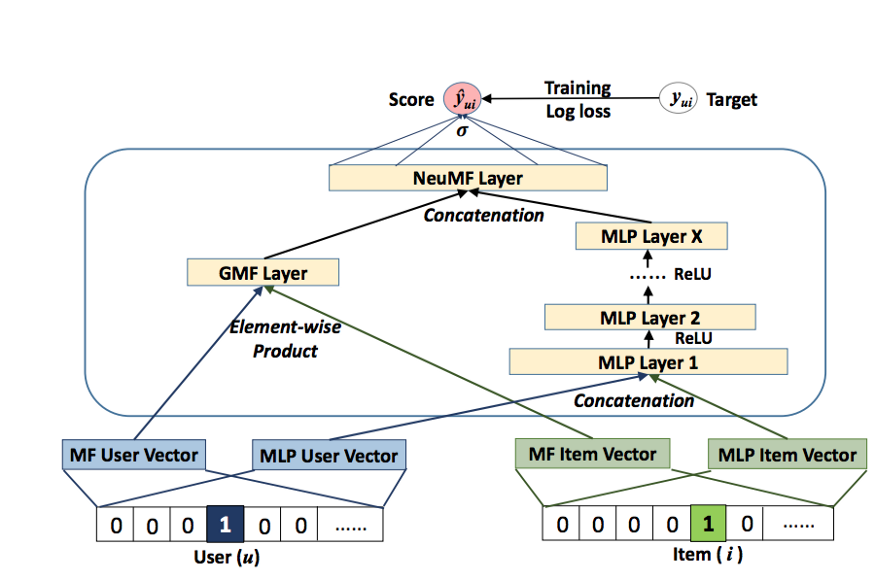

Neural Collaborative Filtering(NCF) replaces the user-item inner product with a neural architecture. By doing so NCF tried to achieve the following:
NCF tries to express and generalize MF under its framework.
NCF tries to learn User-item interactions through a multi-layer perceptron (MLP).

It is important to note that both, the GMF and the MLP component of the NCF have separate item and user embeddings, as it can optimize the embeddings such that it can learn the user-item interaction better.

NCF uses the sigmoid activation function for the GMF output as it can help the model to learn the edge weights from the data using the log loss function, whereas ReLU is the activation function used for the MLP.
The backbone of NCF is considered as the NeuMF layer as shown in the figure, where the outputs from the GMF and MLP are concatenated and used as the input to this layer.




In [88]:
# building neural collaborative filtering model
def build_model(
    total_users: int,
    total_items: int,
    latent_dim_matrix: int = 4,
    latent_dim_p: int = 32,
    matrix_reg: int = 0,
    mlp_reg: int = 0.01,
    dense_layers: List[int] = [10, 10, 10],
    reg_layers: List[int] = [0.01, 0.01, 0.01],
    activation_dense: str = "relu",
) -> keras.Model:

    # input layer
    user = Input(shape=(), dtype="int32", name="user_id")
    item = Input(shape=(), dtype="int32", name="item_id")

    # embedding layers for matrix factorization
    matrix_user_embedding = Embedding(
        input_dim=total_users,
        output_dim=latent_dim_matrix,
        name="matrix_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(matrix_reg),
        input_length=1,
    )
    matrix_item_embedding = Embedding(
        input_dim=total_items,
        output_dim=latent_dim_matrix,
        name="matrix_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(matrix_reg),
        input_length=1,
    )

  # embedding layers for multi-layer perceptron
    user_embedding_mlp = Embedding(
        input_dim=total_users,
        output_dim=latent_dim_p,
        name="mlp_user_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(mlp_reg),
        input_length=1,
    )
    item_embedding_mlp = Embedding(
        input_dim=total_items,
        output_dim=latent_dim_p,
        name="mlp_item_embedding",
        embeddings_initializer="RandomNormal",
        embeddings_regularizer=l2(mlp_reg),
        input_length=1,
    )

    # Matrix Factorization vector
    matrix_latent_user = Flatten()(matrix_user_embedding(user))
    matrix_latent_item = Flatten()(matrix_item_embedding(item))
    matrix_concat = Multiply()([matrix_latent_user, matrix_latent_item])

    # MLP vector
    user_latent_mlp = Flatten()(user_embedding_mlp(user))
    item_latent_mlp = Flatten()(item_embedding_mlp(item))
    mlp_concat = Concatenate()([user_latent_mlp, item_latent_mlp])

    vec_mlp = mlp_concat

    # build dense layers for model
    for i in range(len(dense_layers)):
        layer = Dense(
            dense_layers[i],
            activity_regularizer=l2(reg_layers[i]),
            activation=activation_dense,
            name="layer%d" % i,
        )
        vec_mlp = layer(vec_mlp)

    prediction_layer = Concatenate()([matrix_concat, vec_mlp])

    result = Dense(
        1, activation="sigmoid", kernel_initializer="lecun_uniform", name="rating"
    )
    output = result(prediction_layer)
    model = Model(
        inputs=[user, item],
        outputs=[output],
    )
    return model

In the above step, we have defined the structure of the Neural Collaborative Filtering model. So, the intuition is that we will be using the outputs from the Matrix Factorization (MF) model alongwith a Multi-layer Perceptron (MLP), and we will combine them to produce accurate predictions.
We will have different embeddings for user and items for each algorithms. The latent dimensions for each algorithm have been initialized and we have also mentioned the number of dense layers with the number of neurons in each layer, alongwith a regularization parameter. The activation function for the combined output is a sigmoid activation function. The loss function of the NCF model is the binary cross-entropy. This is because as we are dealing with implicit feedback the interaction can be represented as 0 or 1, in such case, we can treat it as a binary classification problem.

**Building the NCF Model**

We are going to build the Neural Collaborative Filtering model. We will have pass the total number of users and items as the parameters. The optimizer to be used will be Adam optimizer, and the loss function for this model would be the Binary Cross-Entropy.

In [89]:
# defining the number of users and items
all_users, all_items = (3466, 9004)

# building the model
model_ncf = build_model(all_users, all_items)

# defining the optimizer and the loss function
model_ncf.compile(
    optimizer=Adam(),
    loss="binary_crossentropy"
)

**Pandas Dataset to TensorFlow Dataset**

It is seen that often while working with deep learning models, the source of the data would be in Pandas, we need to convert these dataframes into a TensorFlow one so that it becomes readable in TensorFlow, using which we can create pipelines for the model to train on.

In [94]:
# Make TensorFlow dataset from Pandas DataFrame.

def convert_df(
    df: pd.DataFrame,
    targets: List[str],
    val_split: float = 0.1,
    batch_size: int = 512,
    seed=42,
):
    n_val = round(df.shape[0] * val_split)
    if seed:
        # shuffle all the rows
        x = df.sample(frac=1, random_state=seed).to_dict("series")
    else:
        x = df.to_dict("series")
    y = dict()
    for t in targets:
        y[t] = x.pop(t)
    ds = tf.data.Dataset.from_tensor_slices((x, y))

    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)
    return ds_train, ds_val

In [91]:
train_ds = convert_df(df_train, ["rating"])

**Model Training**

We will be using the converted TensorFlow dataset to fit our NCF model on, and will be training it for 5 epochs.

In [92]:
training_model = model_ncf.fit(
    train_ds,
    epochs=5,
    verbose=1,
)

Epoch 1/5
54858/54858 [==============================] - 364s 7ms/step - loss: 0.0317
Epoch 2/5
54858/54858 [==============================] - 357s 6ms/step - loss: 0.0214
Epoch 3/5
54858/54858 [==============================] - 358s 6ms/step - loss: 0.0212
Epoch 4/5
54858/54858 [==============================] - 370s 7ms/step - loss: 0.0211
Epoch 5/5
54858/54858 [==============================] - 382s 7ms/step - loss: 0.0211


We can see that as the number of epochs increases, the loss tends to decrease very slightly and it converges to 0.0211 at the end. This indicates that 5 epochs are sufficient for training our model.

In [95]:
test_table = convert_table(x, unique_ratings)
df_test = pd.DataFrame(test_table, columns=["user_id", "item_id", "rating"])
ds_test, _ = convert_df(df_test, ["rating"], val_split=0, seed=None)

**Making Predictions and Ranking**

In this step, we will use our trained NCF model to make predictions for each user. From this predictions, we will rank them based on the 100 candidate items given in test dataset. Basically, this will help us rank the top 15 recommendations for each user from items in the test set.

In [96]:
# storing predictions
all_predictions = model_ncf.predict(ds_test)
df_test["predictions"] = all_predictions

In [97]:
# calculating the top 15 predictions for each user, and adding it to a dataframe
column_names = ["user_id", "item_id"]
df2 = pd.DataFrame(columns = column_names)
for i in range(3466):
  #print(i)
  a = df_test.loc[df_test['user_id'] == i,]
  b = a.sort_values('predictions', ascending = False)
  c = b.item_id.tolist()
  y = test.loc[test['user_id'] == i,'item_id'].tolist()
  t = []
  u = []
  count = 0
  for j in c:
    if count < 15:
      if j in y:
        t.append(j)
        u.append(i)
        count = count + 1
    else:
      break
  recommendations = pd.DataFrame({'user_id': u, 'item_id': t})
  df2 = df2.append(recommendations, ignore_index=True)

In [98]:
df2.shape

(51990, 2)

In [99]:
df2["user_id"] = df["user_id"].astype(float).astype(int)
df2["item_id"] = df["item_id"].astype(float).astype(int)
df2.to_csv('neural.csv', index=False)

**Observations**

We have successfully built 4 different models to recommend items to the users. From our analysis, we identified that the model built using the Alternating Least Squares algorithm outperformed the other 3 models. A possible reason for this outcome would be the fact that in ALS we minimize the entire loss function at once, by adjusting half the parameters, as the loss function is quadratic in nature and has an easy solution, when half the parameters are fixed. Hence, due to this there is no gradient in each optimization step as the problem is convex. 

**Part B - Node Clustering**

Clustering is an algorithm from the unsupervised domain of Machine Learning, where we can cluster similar objects together based on their features. In this section, we will be performing different types of clustering such K-Means, Agglomerative Clustering & Spectral Clustering.

**Data**

The data provided to us consists of different articles, where the information segregated into 3 different text files. The information in the files are given below:
1. **docs.txt** : contains the article ID, which we will be using as our NodeID, and also the title of corresponding article
2. **adjedges.txt** : This file consists of the relationship between 2 articles. If there exists an edge between 2 articles, this suggests that the 2 articles are related.
3. **labels.txt** : This file consists of the labels for each article. We primarily have 5 labels in total.

Before performing different types of clustering, we will use 2 different types of input for clustering:
1. Word Embeddings : We will convert the titles of each article into embeddings using Word2Vec.
2. Node Embeddings: We will represent each node as an embedding using Node2Vec before passing it as an input to different clustering algorithms.

**Description of Clustering Algorithms** :-
There are mainly 3 types of algorithms that we will be using for our task, these are as follows:
1. K-Means Clustering : This is the simplest clustering algorithm, where we can iteratively assign labels to the data points based on their features.
2. Agglomerative Clustering: The main idea behind agglomerative clustering is that each node starts in its own cluster, and recursively merges with the pair of clusters that minimally increases a given linkage distance.
3. Spectral Clustering : This is an algorithm primarily based on graph theory, where we can classify a node into a community based on the edges connecting them.

**Importing Libraries**

In [100]:
import time
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# for building the graph
import networkx as nx

import seaborn as sns
%matplotlib inline

**Creating the graph using the data**

As mentioned above, our data is segregated into 3 text files. Hence, we will be extracting the information by reading the files into our notebooks and by iterating over them line by line.

**Adding Nodes**

Each line in the docs.txt file consists of a document ID and a title. We will use the ID to represent the node and the title will be considered as the content of each node.

In [101]:
# adding nodes to the graph
lines = []
# empty graph
g = nx.Graph()

# reading and building the grapj
with open('docs.txt', "r") as f:
    lines = f.readlines()
    for i in lines:
      s = i.split(" ", 1)
      # adding nodes to the graph
      g.add_node(s[0].strip(), title = s[1].strip())

**Adding labels**

The labels.txt consists of the labels for each article. We will be assigning each article a label by iterating over this file and creating a new key with the label value for each node.

In [102]:
# adding content for the nodes
labels = []
with open('labels.txt', "r") as f:
    labels = f.readlines()
    for j in labels:
      s = j.split(" ")
      lbl = s[1].split(" ")[0].strip()
      g.add_node(s[0].strip(), label = lbl)

**Adding edges**

An edge denotes a relationship between 2 articles. We will be creating edges/links between 2 articles using the adjedges.txt file. 

***NOTE***: there are many document ID's that does not have an entry in the other 2 text files. We will be excluding all such articles. For example, document with ID '40935482' exists in the adjedges file, but does not exists in the other 2 files. So, we will exclude such articles from our analysis.

In [103]:
# storing the node and corresponding edges
edges = []
with open('adjedges.txt', "r") as f:
  edges = f.readlines()
  for k in edges:
    s = k.split(" ")
    r = s[1:]
    for i in r:
      # exclude irrelevant articles
      if (len(i) > 1) and (i in g.nodes()):
        g.add_edge(s[0],i.strip())

In [104]:
# checking a node in our graph
print(g.nodes['3982162'])
print(g.edges('68660241'))

{'title': 'Discovering Statistically Significant Biclusters in Gene Expression Data', 'label': '1'}
[('68660241', '39297346'), ('68660241', '3982162'), ('68660241', '77686302'), ('68660241', '63138342'), ('68660241', '76594210')]


In [105]:
num_nodes = g.number_of_nodes()
print('number of nodes: ' + str(num_nodes))
num_edges = g.number_of_edges()
print('number of edges: ' + str(num_edges))

number of nodes: 18720
number of edges: 7641


**Experimental Setting**

Before using different embedding techniques, we will just the graph data as it is and perform clustering. This is done so that we have a baseline to evaluate the performance of different embeddings.

In [108]:
# building laplacian matrix
L = nx.laplacian_matrix(g).astype(float)


In [109]:
# computing eigen values and eigen vectors of the above matrix, where k = 5 is the size of each vector
w,v = sp.sparse.linalg.eigsh(L, k = 5, which='SM')
print(w)
print(v)

[-4.51986385e-14 -3.08706010e-14  7.72717302e-16  1.70400190e-14
  5.14022174e-14]
[[ 1.51841437e-03  4.87377362e-03 -5.26402532e-04  6.34776332e-03
  -9.72353515e-03]
 [-1.21319781e-04 -1.16566695e-03  8.49527928e-04 -5.28025178e-04
  -6.66741315e-03]
 [ 2.89622183e-04  7.80129656e-04  2.56195112e-03 -2.80506295e-03
   1.01600639e-02]
 ...
 [ 8.70968895e-05 -1.63357631e-03  1.58625062e-03 -2.93237187e-03
  -1.27691340e-02]
 [-5.61096389e-04 -3.20044317e-03 -4.70336133e-03 -1.53778554e-03
  -6.25562391e-03]
 [ 9.55036888e-05 -1.84300629e-04 -3.14982848e-05  2.85215846e-04
  -9.69805555e-03]]


In [110]:
print(w.shape, v.shape)
# matrix multiplication to get the input matrix X
X = v*w

(5,) (18720, 5)


In [111]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score

nmi_kmeans = []
nmi_agg = []
nmi_spectral = []
seed_values = [10, 50, 100, 150, 200, 300, 500, 700, 800, 900]
true_labels = []
l = list(g.nodes())
for i in l:
  true_labels.append(int(g.nodes[i]['label']))
truth_labels = np.asarray(true_labels)

for i in seed_values:
  #print(i)
  np.random.seed(i)
  # K-Means Clustering
  kmeans = KMeans(init='k-means++', n_clusters=5, n_init=i)
  # Agglomerative Clustering
  agg = cluster.AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage="ward").fit(X)
  # Spectral Clustering
  spec_clustering = cluster.SpectralClustering(
        n_clusters=5, eigen_solver='arpack',
        affinity="nearest_neighbors").fit(X)
  
  # Computing Predictions
  kmeans.fit_predict(X)
  centroids = kmeans.cluster_centers_
  k_means_labels = kmeans.labels_
  error = kmeans.inertia_
  agg_labels = agg.labels_
  spec_labels = spec_clustering.labels_

  # Computing NMI scores
  nmi_kmeans.append(normalized_mutual_info_score(truth_labels, k_means_labels))
  nmi_agg.append(normalized_mutual_info_score(truth_labels, agg_labels))
  nmi_spectral.append(normalized_mutual_info_score(truth_labels, spec_labels))
  
  
print("K-means Clustering Avg NMI: ", sum(nmi_kmeans)/len(nmi_kmeans))
print("Agglomerative Clustering Avg NMI: ", sum(nmi_agg)/len(nmi_agg))
print("Spectral Clustering Avg NMI: ", sum(nmi_spectral)/len(nmi_spectral))


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklea

K-means Clustering Avg NMI:  0.12802166859531885
Agglomerative Clustering Avg NMI:  0.1242298239515969
Spectral Clustering Avg NMI:  0.043414780791132555


**1. Clustering using Word Embeddings**

Word Embeddings are mainly used to represent textual data in a sparse format. These embeddings can be used as an input to perform different machine learning algorithms. 

For our task, we will represent the title of each node as an embedding using Word2Vec.
Word2vec is a technique for natural language processing. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.


**Fetching the titles**

We will be gathering all the titles to create the embeddings. We have performed a small preprocessing step of converting the title into lowercases, so that there is consistency between all the titles. Each word in the title will be represented as a token.


In [112]:
# list to store 
titles = []
for i in g.nodes():
  # converting to lowercase and splitting
  s = g.nodes[i]['title'].lower().split()
  titles.append(list(s))
len(titles)

18720

In [113]:
# checking the first value
titles[0]

['assessing',
 'local',
 'institutional',
 'capacity,',
 'data',
 'availability,',
 'and',
 'outcomes',
 'by']

**Building the Word2Vec Model**

We will be using the gensim.models to build the Word2Vec model. We have used certain parameter values to get results in our favour.
The **size** parameter indicates the embedding size of each word. We have initialized it as 16, so that the length of each word embedding would be the same.

In [114]:
from gensim.models import Word2Vec

model = Word2Vec(titles, min_count=1,size=16,workers=4)

Since we are going to perform clustering based on the titles, and not based on single words. We have created a function to calculate the mean embedding of the words in a sentence. This function will add the embeddings of each word in that sentence and return the mean embedding which represents a sentence.

In [115]:
def sentence_vec(s, model):
    word_vec =[]
    sent_len = len(s)
    for w in s:
      #  try:
      word_vec = model[w]
      word_vec = np.add(word_vec, model[w])
            #numw+=1
       # except:
        #    pass
     
    return np.asarray(word_vec) / sent_len

In [116]:
# getting the sentence embeddings
X=[]
for sentence in titles:
    X.append(sentence_vec(sentence, model))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


**Performing Clustering**

We will be performing different clustering algorithms on the word embeddings and will evaluate the performance of each algorithm using **Normalized Mutual Information Score (NMI)**. This score indicates how well the clustering algorithm does in predicting the label of each node.In other words NMI can be used to evaluate the quality of clustering.

Since most clustering algorithms are sensitive to initial values, we have decided to use 10 seed values and calculate the mean of the NMI's for each seed, and use that to denote as the final scores for each algorithm.

In [117]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score

nmi_kmeans = []
nmi_agg = []
nmi_spectral = []
seed_values = [10, 50, 100, 150, 200, 300, 500, 700, 800, 900]
true_labels = []
l = list(g.nodes())
for i in l:
  true_labels.append(int(g.nodes[i]['label']))
truth_labels = np.asarray(true_labels)

for i in seed_values:
  print(i)
  # setting seed
  np.random.seed(i)
  # Kmeans clustering
  kmeans = KMeans(init='k-means++', n_clusters=5, n_init=i)
  # Agglomerative Clustering
  agg = cluster.AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage="ward").fit(X)
  # Spectral Clustering
  spec_clustering = cluster.SpectralClustering(
        n_clusters=5, eigen_solver='arpack',
        affinity="nearest_neighbors").fit(X)
  
  # Computing predictions
  kmeans.fit_predict(X)
  centroids = kmeans.cluster_centers_
  k_means_labels = kmeans.labels_
  error = kmeans.inertia_
  agg_labels = agg.labels_
  spec_labels = spec_clustering.labels_

  # NMI Computation
  nmi_kmeans.append(normalized_mutual_info_score(truth_labels, k_means_labels))
  nmi_agg.append(normalized_mutual_info_score(truth_labels, agg_labels))
  nmi_spectral.append(normalized_mutual_info_score(truth_labels, spec_labels))
  
  
print("K-means Clustering Avg NMI: ", sum(nmi_kmeans)/len(nmi_kmeans))
print("Agglomerative Clustering Avg NMI: ", sum(nmi_agg)/len(nmi_agg))
print("Spectral Clustering Avg NMI: ", sum(nmi_spectral)/len(nmi_spectral))


10


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


50


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


100


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


150


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


200


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


300


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


500


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


700


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


800


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


900


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


K-means Clustering Avg NMI:  0.012084556013289205
Agglomerative Clustering Avg NMI:  0.011315142852301993
Spectral Clustering Avg NMI:  0.00978090280394504


**Node Embeddings**

In this section, we will be embedding one of the graph components, which will be further used as an input for different clustering algorithms. We will be doing node embedding using Node2Vec.

Node2Vec is an algorithmic framework for representational learning on graphs. Given any graph, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning tasks. The model learns low-dimensional representations for nodes by optimizing a neighborhood preserving objective, using random walks. 

To install the package, simply run:  pip install Node2Vec

In [106]:
!pip install Node2Vec


  Created wheel for Node2Vec: filename=node2vec-0.4.3-cp37-none-any.whl size=5980 sha256=b108b1db0cf355321b69c079a045b8a3b82bb1ab3af5fc32c955bb7bd1092f0b
  Stored in directory: /root/.cache/pip/wheels/34/f4/60/55708b5e797260310451d919c8f898bbd4acd1901367001f20
Successfully built Node2Vec


**Building Node2Vec Model**

We will build the Node2Vec model based on the following parameters.

Dimensions: We will use the same as of the word embeddings. Hence, we set this value to 16.

Number of walks: Number of random walks to be generated from each node in the graph. We have set this to 20.

Walk length: Denotes the number of nodes in each walk. We have set this value to 50.

In [118]:
from node2vec import Node2Vec
#pre-compute the probabilities and generate walks :
node2vec = Node2Vec(g, dimensions=16, walk_length=20, num_walks=50, workers=4)
#embed the nodes
model = node2vec.fit(window=10, min_count=1)

**Getting the node embeddings for each Node**

We will be fetching the node embeddings of each node using our model, and we will store these embeddings to a list.

In [119]:
node_emb_list = []
for i in g.nodes():
  node_emb_list.append(model.wv.get_vector(str(i)))
len(node_emb_list)
# using X to represent input, for simplicity 
X = node_emb_list

**Performing Clustering**

Similar to how we performed clustering using the word embeddings, we will be doing the same for node embeddings too.

In [120]:
nmi_kmeans = []
nmi_agg = []
nmi_spectral = []
seed_values = [10, 50, 100, 150, 200, 300, 500, 700, 800, 900]
true_labels = []
l = list(g.nodes())
for i in l:
  true_labels.append(int(g.nodes[i]['label']))
truth_labels = np.asarray(true_labels)

for i in seed_values:
  print(i)
  # setting seed
  np.random.seed(i)
  # Kmeans clustering
  kmeans = KMeans(init='k-means++', n_clusters=5, n_init=i)
  # Agglomerative Clustering
  agg = cluster.AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage="ward").fit(X)
  # Spectral Clustering
  spec_clustering = cluster.SpectralClustering(
        n_clusters=5, eigen_solver='arpack',
        affinity="nearest_neighbors").fit(X)
  
  # Computing predictions
  kmeans.fit_predict(X)
  centroids = kmeans.cluster_centers_
  k_means_labels = kmeans.labels_
  error = kmeans.inertia_
  agg_labels = agg.labels_
  spec_labels = spec_clustering.labels_

  # NMI Computation
  nmi_kmeans.append(normalized_mutual_info_score(truth_labels, k_means_labels))
  nmi_agg.append(normalized_mutual_info_score(truth_labels, agg_labels))
  nmi_spectral.append(normalized_mutual_info_score(truth_labels, spec_labels))
  
  
print("K-means Clustering Avg NMI: ", sum(nmi_kmeans)/len(nmi_kmeans))
print("Agglomerative Clustering Avg NMI: ", sum(nmi_agg)/len(nmi_agg))
print("Spectral Clustering Avg NMI: ", sum(nmi_spectral)/len(nmi_spectral))


10


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


50


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


100


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


150


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


200


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


300


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


500


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


700


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


800


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


900


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


K-means Clustering Avg NMI:  0.2522711966343788
Agglomerative Clustering Avg NMI:  0.26604520406970394
Spectral Clustering Avg NMI:  0.260486552166395


**Observations**

The result of each algorithm using the word embeddings were significantly lower when kept in comparison with the baseline setup. The average NMI score for each algorithm was less than 0.1. This indicates that we needed more information and not just the titles to efficiently form the embeddings, where perhaps would have given a higher NMI score. 

The node embeddings outperformed the latter 2 settings, as we got significantly higher scores for each algorithm. This technique proved effective as we believe we had enough information to represent these nodes as embeddings. In terms of NMI scores, the Agglomerative clustering performed relatively better than K-Means and significantly better than Spectral Clustering, as spectral clustering did not perform well since the affinity matrix required for the clustering was not a fully connected matrix.
